In [174]:
############# LIBRERIAS:

import networkx as nx
import random
import numpy as np
from random import choice
from numba import njit
import matplotlib.pyplot as plt
from collections import Counter
import pickle
from datetime import datetime
from tqdm import trange
import functions

def isintrace(pos, trace):
    
    ''' Chequea si el elemento pos, correspondiente al par ordenado que denota la posicion de una particula
    nueva se ecuentra ya en la traza. '''
    
    # for i in trace:
    #     if np.allclose(pos, i, rtol= 1e-3):
    #         return True
    # return False
    #print(pos-trace)
    bools = np.sum(np.abs(pos-trace), axis=1) <= 1e-3
    return np.sum(bools) > 0

origen= np.array([0,0]) # Al tener el origen fuera, se agiliza un poco la función boundary

def boundary(origen, position, r_max): 
    
    ''' Calcula el radio máximo del movimiento como la máxima distancia que puede
    moverse la partícula en línea recta durante el tiempo de la simulación . Luego,
    calcula la distancia desde el origen a la posicion de la partícula que
    se movió (la entregada por direction). Si dicha distancia es menor al radio máximo, retorna True. '''
    
    distancia= np.hypot( position[0]- origen[0], position[1]- origen[1])
    
    #np.hypot caclula la hipotenusa entre dos puntos; en el espacio euclideo es igual a la norma

    if distancia <= r_max :
        return True 
    
    return False

def direction(pos, Trace):
    
    ''' Le da una dirección de movimiento a las partículas a partir de la posicion de la particula
    que va a moverse pos, revisando los vecinos mas cercanos de la partícula en ese momento, cuyas posiciones
    son dadas por pos_tmp. Luego, anexa en una matriz las posiciones que no están ocupadas revisando la
    traza Trace. Finalmente elige al azar una posicion de la matriz.'''
    
    opciones = np.array([[1, 0], [-1, 0], [1 / 2, np.sqrt(3) / 2], [-1 / 2, np.sqrt(3) / 2], [-1 / 2, -np.sqrt(3) / 2],
                          [1 / 2, -np.sqrt(3) / 2]])
    
    pos = pos + opciones  # Modificar pos directamente
    posibles = []

    for neighbor in pos:
        if isintrace(neighbor, Trace):
            pass
        else:
            posibles.append(neighbor)

    if np.any(posibles):
        posicion = choice(posibles)
        if boundary(origen, posicion, 4):
            return posicion

    return []


def edge_list(edges, T, source, target):
    '''
    Esta función toma las posiciones de los nodos (que corresponde simplemente 
    a la traza) y la dirección en la que se genera la arista 'edge' desde source hasta target.
    
    Recordar que np.append junta un array con un valor en un eje especificado. Por
    lo tanto, se le debe entregar las coordenadas en arreglos, como Trace.
    Edges tiene que ser un arreglo al que le vamos anexando conexiones e indica las conexiones que se hacen 
    de acuerdo a los indices de traza.  
    
    Source y target son índices de los nodos en Trace. Serán la i-ésima partícula moviéndose y N, respectivamente.
    '''
    edges= np.append (edges, np.array([ [source, target] ]) , axis=0)
    return edges


def action(G, edges, pos, Trace, ind_tmp, i, N):
    
    ''' Toma un grafo G y un arreglo edges que indica las conexiones que se van dando entre los nodos 
    indexados. Pos corresponde a la posicion de la particula que decide moverse(que debe entregar direction)
    por lo que corresponde
    a un par odenado (x,y), y Trace el arreglo de todas las posiciones que se han ocupado. 
    Además,  ind_tmp son los indices de las particulas temporalmente activas. 
    
    Por ultimo i, N son los índices de las partículas fuente y objetivo en las que se generan
    las conexiones, respectivamente. ''' 
    
    pos_tmp = np.copy(pos)
    pos_tmp= direction(pos, Trace)# direction revisa las posiciones posibles y elige una que no está en la traza
    
    if np.any(pos_tmp):
        #si es que hay algun elemento elegido, lo agregamos a traza. Después hay que ver si ese punto
        #cunple con la condicion de borde 
        Trace= np.concatenate( (Trace, [pos_tmp]) , axis=0)
        N += 1
        ind_tmp.append(N) #anexamos el indice activo a la enésima partícula
        
        edges= edge_list(edges, Trace, i, N ) #source es un indice de la traza, y target tambien
        G.add_node(N, pos= (pos_tmp[0], pos_tmp[1]))
            
         
    return G, Trace, N, edges, ind_tmp #ind_part_activas 



def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))
            
    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)


def clean(G): 
    '''  Toma un grafo G y saca los nodos que tienen grado dos, quitando también las
    conexiones entre esos nodos'''
    import copy 
    copia= copy.copy(G)
    nodos= G.nodes
   
    
    for i in range(len(copia.nodes)): 
        
        if copia.degree(i)== 2 and i != 0: 
            neighbours = [n for n in copia[i]]
            copia.add_edge(neighbours[0], neighbours[1])
            copia.remove_node(i)

        else: 
            pass 
            
    return  nodos , copia  

def degree_distribution(nfiles):
    degrees = np.zeros((nfiles, 6))

    for n in range(nfiles):
        filename = 'Graph%i.pickle' % n
        with open(filename, 'rb') as archivo:
            G = pickle.load(archivo)
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
        ndegree = Counter(degree_sequence)
        deg, cnt = zip(*ndegree.items())
        degrees[n, np.array(deg) - 1] = cnt

    total_histogram = np.sum(degrees, axis=0)
    x = np.arange(1, 7)

    plt.style.use('bmh')
    plt.grid(False)
    plt.xlabel(r'$k$', fontsize=15)
    plt.ylabel(r'$\mathcal{P}(k)$', fontsize=15)
    plt.yscale('log')
    plt.title('Distribución de grados')

    plot_1 = plt.bar(x, total_histogram, color='#669BBC')
    
    plt.show()

    return plot_1


def topological_generations(G):
    """Stratifies a DAG into generations.

    A topological generation is node collection in which ancestors of a node in each
    generation are guaranteed to be in a previous generation, and any descendants of
    a node are guaranteed to be in a following generation. Nodes are guaranteed to
    be in the earliest possible generation that they can belong to.

    Parameters
    ----------
    G : NetworkX digraph
        A directed acyclic graph (DAG)

    Yields
    ------
    sets of nodes
        Yields sets of nodes representing each generation.

    Raises
    ------
    NetworkXError
        Generations are defined for directed graphs only. If the graph
        `G` is undirected, a :exc:`NetworkXError` is raised.

    NetworkXUnfeasible
        If `G` is not a directed acyclic graph (DAG) no topological generations
        exist and a :exc:`NetworkXUnfeasible` exception is raised.  This can also
        be raised if `G` is changed while the returned iterator is being processed

    RuntimeError
        If `G` is changed while the returned iterator is being processed.

    Examples
    --------
    >>> DG = nx.DiGraph([(2, 1), (3, 1)])
    >>> [sorted(generation) for generation in nx.topological_generations(DG)]
    [[2, 3], [1]]

    Notes
    -----
    The generation in which a node resides can also be determined by taking the
    max-path-distance from the node to the farthest leaf node. That value can
    be obtained with this function using `enumerate(topological_generations(G))`.

    See also
    --------
    topological_sort
    """
    if not G.is_directed():
        raise nx.NetworkXError("Topological sort not defined on undirected graphs.")

    multigraph = G.is_multigraph()
    indegree_map = {v: d for v, d in G.in_degree() if d > 0}
    zero_indegree = [v for v, d in G.in_degree() if d == 0]

    while zero_indegree:
        this_generation = zero_indegree
        zero_indegree = []
        for node in this_generation:
            if node not in G:
                raise RuntimeError("Graph changed during iteration")
            for child in G.neighbors(node):
                try:
                    indegree_map[child] -= len(G[node][child]) if multigraph else 1
                except KeyError as err:
                    raise RuntimeError("Graph changed during iteration") from err
                if indegree_map[child] == 0:
                    zero_indegree.append(child)
                    del indegree_map[child]
        yield this_generation

    if indegree_map:
        raise nx.NetworkXUnfeasible(
            "Graph contains a cycle or graph changed during iteration"
        )
        
    
def generar_arboles(nfiles):
    '''Genera una lista de subárboles dirigidos a partir de cada grafo.'''
  
    arboles = []
    
    for n in range(nfiles): 
        filename = 'Graph%i.pickle' % n
        with open(filename, 'rb') as archivo:
            G = pickle.load(archivo)
        
        # Limpia el grafo original en lugar de hacer una copia
        _, _ = clean(G)
        
        # Genera un árbol dirigido directamente y agrégalo a la lista
        arbol = nx.dfs_tree(G, 0)
        arboles.append(arbol)
        
    return arboles


def subarboles(arbol, gen):   
    generaciones = [sorted(generation) for generation in topological_generations(arbol)] 
    nodos = generaciones[gen] 
    cantidad_subarboles = len(nodos)  # Calcula la cantidad de subárboles una vez

    persistencia = []
    tamaño = []

    for i in range(cantidad_subarboles):
        subarbol = nx.dfs_tree(arbol, nodos[i])
        subgenerations = [sorted(generation) for generation in topological_generations(subarbol)]
        
        # Calcula la persistencia y el tamaño en función del subárbol actual
        persistencia.append(len(subgenerations))
        tamaño.append(len(subarbol.edges()))

    return cantidad_subarboles, persistencia, tamaño


def runrun(n):
    start_time = datetime.now()

    #---------------------------------DATOS DEL PROBLEMA--------------------------------------------------

    tmax= 10#tiempo maximo de simulacion
    t= 0.0 #tiempo inicial 
    h= 1 #paso de tiempo
    s= 5.0
    
    #--------------------------------- MAIN CODE---------------------------------------------------------

    edges =np.empty([0, 2])

    origen= np.array( [0,0])

    T = np.array([[0,0]]) 
    pos= np.array([ 0, 0]) # posicion de las particulas que se van añadiendo/ [Indice, (par ordenado)] 

    ind_part_activas= np.array([0]) #define el indice de la posicion de las particulas activas en T

    N= 0


    G= nx.Graph()
    G.add_node(0, pos= (0,0))
    t = 0

    while t < tmax  and len(ind_part_activas) >0  :
        # if not len(ind_part_activas) >0:
        #     break
        ind_tmp = []
        # t = q*h

        #t += h # tiempo= tiempo+ h

        randperms = np.random.permutation(ind_part_activas)

        ind_mover= np.random.choice(ind_part_activas) 

        r= np.random.uniform(0,1) 

        pos= T[ind_mover]
        N_activas= len(ind_part_activas)

        if r < 1 :

            G, T, N, edges, ind_tmp = action(G, edges, pos, T, ind_tmp,ind_mover, N)
            G, T, N, edges, ind_tmp = action(G, edges, pos, T, ind_tmp,ind_mover, N)
        else:

            G, T, N, edges, ind_tmp =  action(G, edges, pos, T, ind_tmp,ind_mover, N)


        ind_part_activas=np.append(ind_part_activas,ind_tmp).astype(int)
        ind_part_activas=np.delete(ind_part_activas, np.where(ind_part_activas == ind_mover)) 
        G.add_edges_from(edges)

        with open('Graph'+str(n)+'.pickle', 'wb') as archivo:
            pickle.dump(G, archivo)


    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))

In [67]:
############## GENERAMOS UNA SERIE DE GRAFOS DE RADIO 25:

#for i in range(80):
#    runrun(i)

KeyboardInterrupt: 

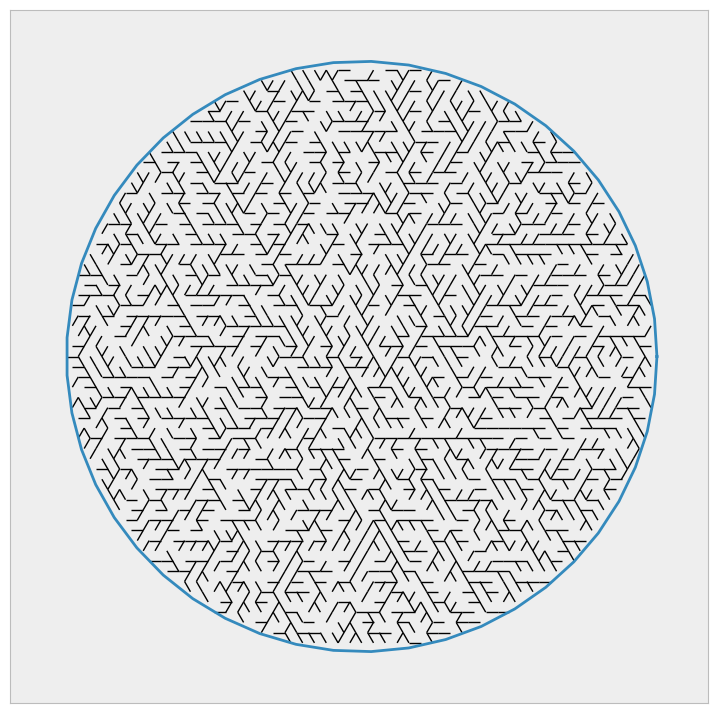

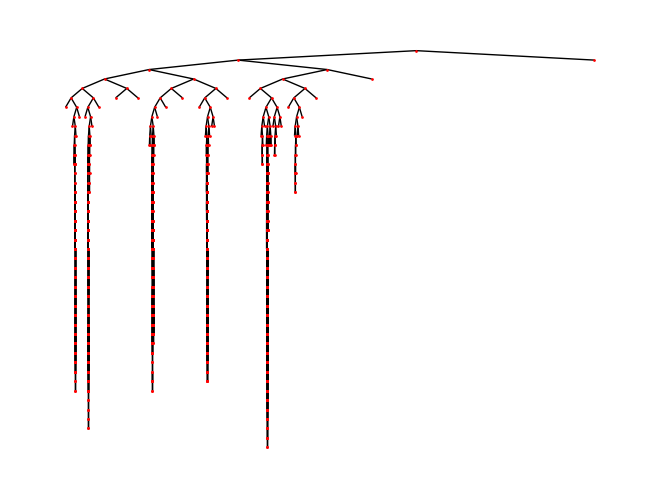

In [54]:
########### GRAFICAR UN ARBOL ORIGINAL:

with open('Graph1.pickle', 'rb') as archivo:
    G = pickle.load(archivo)

plt.figure(figsize=(9,9))
plt.axis('equal')   
plt.style.use('bmh')
plt.grid(False)
   
angle = np.linspace( 0 , 2 *np.pi) 
 
radius = 25
x = radius * np.cos( angle ) 
y = radius * np.sin( angle ) 

plt.plot( x, y ) 

    
x= nx.get_node_attributes(G, 'pos')

G.add_edges_from(G.edges)

nx.draw_networkx_nodes(G,x, node_shape='.', node_size=0.0, alpha= 0 )
nx.draw_networkx_edges(G,x)

#plt.savefig('red_revive.pdf')
plt.show()


nodos, copia = clean(G) #limpia la red quitando los nodos de grado 2
arbol= nx.dfs_tree(G, 0) #genera un arbol genealogico DIRIGIDO

tree_2= functions.hierarchy_pos(arbol,0) #Toma el arbol no dirigido y lo ordena 
nx.draw(G, tree_2 ,node_color= 'red', node_size= 2) #dibuja el arbol dirigido 
plt.savefig('red_revive2.pdf')
plt.show()

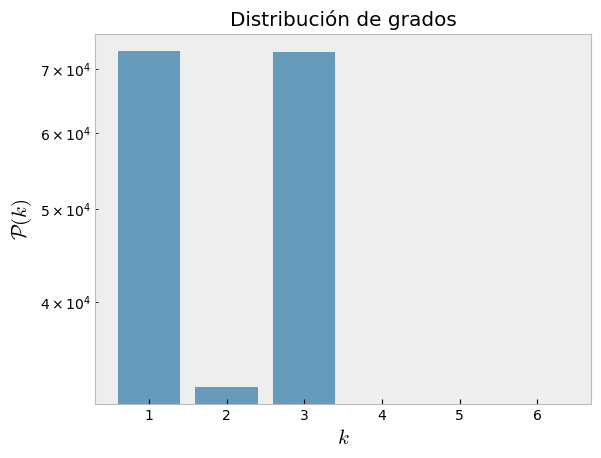

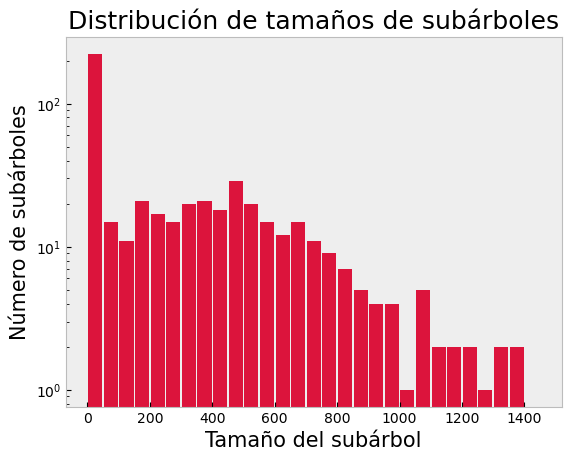

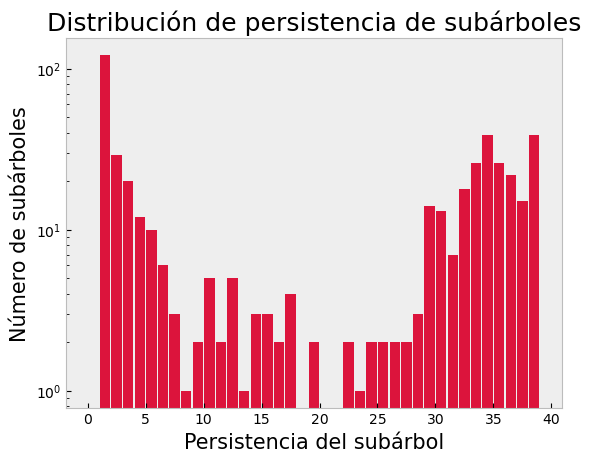

In [53]:
##### GRAFICAMOS DISTRIBUCION DE GRADOS:

degree_distribution(79)

arbolitos = generar_arboles(79)
tamaño = []
persistencia = []
for tree in arbolitos: 
    
    subarbol= subarboles(tree,3)
    tamaño += subarbol[2]
    persistencia += subarbol[1]

    
##### GRAFICAMOS TAMAÑO Y PERSISTENCIA

plt.style.use('bmh')
plt.hist(tamaño, color='crimson', align= 'mid',bins=np.arange(0,1500,50) , rwidth=0.9, histtype='bar')
#plt.hist(tamaño, color='crimson', align= 'mid',bins=np.arange(0,1200,200) , rwidth=0.8, histtype='bar', cumulative= True)
#plt.title('Distribución acumulada de tamaños de subárboles', fontsize= 18, fontname= 'Helvetica')
plt.title('Distribución de tamaños de subárboles', fontsize= 18) #**csfont)
plt.xlabel('Tamaño del subárbol', fontsize= 15) 
plt.ylabel('Número de subárboles', fontsize=15)
plt.yscale('log')
plt.grid(False)
plt.show()
#me gustaria poner barras por intervalo: por ejemplo, que en el intervalo 0-200 hay 2000 arboles
#
#%%
plt.hist(persistencia, color= 'crimson', align= 'mid', bins= np.arange(0,40, 1), rwidth= 0.9, histtype= 'bar')
plt.title('Distribución de persistencia de subárboles', fontsize= 18)
#plt.hist(tamaño, color='crimson', align= 'mid',bins=np.arange(0,1200,200) , rwidth=0.8, histtype='bar', cumulative= True)
#plt.title('Distribución acumulada de tamaños de subárboles', fontsize= 18, fontname= 'Helvetica')
plt.xlabel('Persistencia del subárbol', fontsize=15) 
plt.ylabel('Número de subárboles', fontsize=15)
plt.yscale('log')
plt.grid(False)

plt.show()

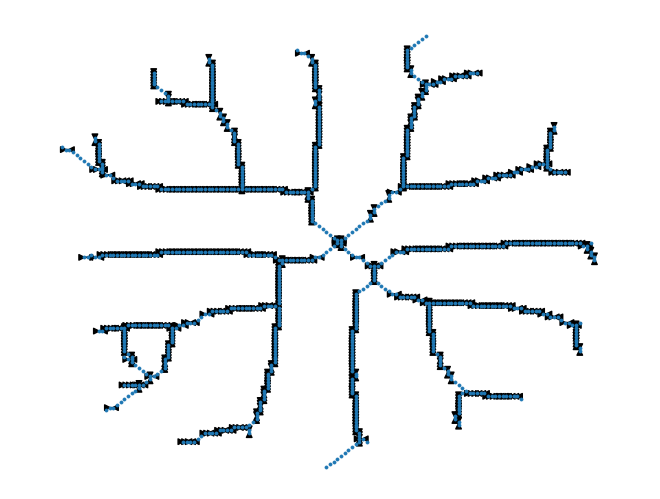

In [59]:
import cv2
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen desde el archivo TIFF
image = cv2.imread('MASK_sample_01_sk-1.tif', cv2.IMREAD_GRAYSCALE)

# Crear un grafo dirigido de NetworkX
grafo_dirigido = nx.DiGraph()

# Obtener las coordenadas de los puntos de inicio y final (extremos) en el esqueleto
def encontrar_puntos_de_extremo(esqueleto):
    puntos_extremo = np.argwhere(esqueleto == 255)  # Encuentra píxeles blancos
    return [(x, y) for x, y in puntos_extremo]

# Agregar nodos al grafo
puntos_extremo = encontrar_puntos_de_extremo(image)
grafo_dirigido.add_nodes_from(puntos_extremo)


def son_vecinos(punto1, punto2, esqueleto):
    """
    Verifica si dos puntos son vecinos en el esqueleto.

    Args:
    - punto1: Tupla con las coordenadas (fila, columna) del primer punto.
    - punto2: Tupla con las coordenadas (fila, columna) del segundo punto.
    - esqueleto: Imagen del esqueleto donde 255 representa píxeles en el esqueleto y 0 otros píxeles.

    Returns:
    - True si los puntos son vecinos en el esqueleto, False en caso contrario.
    """

    # Obtener las coordenadas de los píxeles adyacentes a punto1
    vecinos_punto1 = [(punto1[0] + i, punto1[1] + j) for i in [-1, 0, 1] for j in [-1, 0, 1] if (i != 0 or j != 0)]

    # Verificar si punto2 está entre los vecinos de punto1 y en el esqueleto
    return punto2 in vecinos_punto1 and esqueleto[punto2] == 255

def son_vecinos(punto1, punto2):
    x1, y1 = punto1
    x2, y2 = punto2
    
    # Verificar si los puntos son adyacentes horizontal o verticalmente
    if abs(x1 - x2) + abs(y1 - y2) == 1:
        return True  # Son vecinos
    else:
        return False  # No son vecinos

with open('GraphCAGL.pickle', 'wb') as archivo:
    pickle.dump(G, archivo)

# Agregar aristas al grafo
for punto1 in puntos_extremo:
    for punto2 in puntos_extremo:
        if punto1 != punto2 and son_vecinos(punto1, punto2):
            grafo_dirigido.add_edge(punto1, punto2)

# Graficar el grafo utilizando Matplotlib
posiciones = {nodo: nodo for nodo in grafo_dirigido.nodes()}
nx.draw(grafo_dirigido, posiciones, with_labels=False, node_size=5)
plt.show()


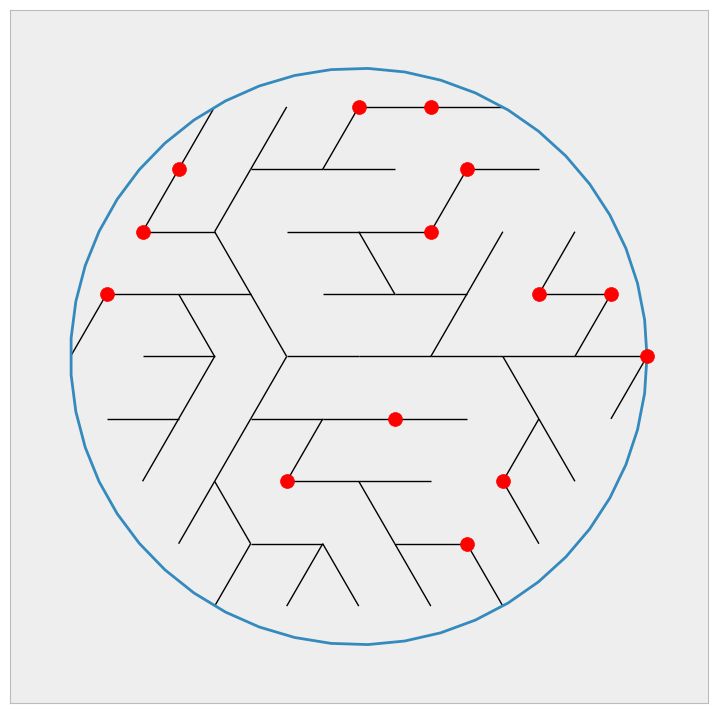

[(0, 1.0), (0, 2.0), (1, 3.0), (1, 4.0), (2, 5.0), (2, 6.0), (3, 11.0), (3, 12.0), (4, 9.0), (4, 10.0), (5, 26.0), (5, 27.0), (6, 7.0), (6, 8.0), (7, 13.0), (7, 14.0), (8, 32.0), (8, 33.0), (9, 15.0), (9, 16.0), (10, 22.0), (10, 23.0), (11, 20.0), (11, 21.0), (12, 17.0), (12, 18.0), (13, 19.0), (14, 57.0), (15, 28.0), (16, 43.0), (17, 38.0), (17, 39.0), (18, 40.0), (19, 52.0), (20, 29.0), (21, 50.0), (21, 51.0), (22, 24.0), (22, 25.0), (24, 36.0), (24, 37.0), (27, 34.0), (27, 35.0), (28, 30.0), (28, 31.0), (30, 41.0), (30, 42.0), (32, 48.0), (34, 44.0), (34, 45.0), (39, 46.0), (39, 47.0), (40, 55.0), (42, 53.0), (45, 54.0), (46, 49.0), (49, 56.0), (50, 59.0), (50, 60.0), (54, 58.0)]
2
61
14


In [158]:
#runrun(80)

with open('Graph80.pickle', 'rb') as archivo:
    G = pickle.load(archivo)

plt.figure(figsize=(9,9))
plt.axis('equal')   
plt.style.use('bmh')
plt.grid(False)
   
angle = np.linspace( 0 , 2 *np.pi) 
 
radius = 4
x = radius * np.cos( angle ) 
y = radius * np.sin( angle ) 

plt.plot( x, y ) 

    
x= nx.get_node_attributes(G, 'pos')

G.add_edges_from(G.edges)

node_colors = ['red' if node == 13 else 'blue' for node in G.nodes()]

nx.draw_networkx_nodes(G, x, nodelist=nodosG2, node_color='red', node_size=100)
nx.draw_networkx_nodes(G,x, node_shape='.', node_size=10.0, alpha= 0)
nx.draw_networkx_edges(G,x)

#plt.savefig('red_revive.pdf')
plt.show()

print(G.edges())
#print(clean(G)[0])
print(G.degree[13])

L = len(G.nodes)
print(L)
print(len(nodosG2))

In [161]:
import copy
#Gprima = G
#nodos, copia = clean(G)
#nodosG2 = []
#for i in np.arange(L):
#    if i not in nodos:
#        nodosG2.append(i)
        
#print(nodosG2)

print(list(G.neighbors(13)))
        

[7.0, 19.0]


In [169]:
def encontrar_ductos(grafo):
    ductos = {}  # Diccionario para almacenar información de los ductos
    visitados = set()  # Conjunto para realizar un seguimiento de los nodos visitados
    
    for nodo in grafo.nodes:
        if grafo.degree(nodo) == 2 and nodo != 0 and nodo not in visitados:
            longitud_ducto = 2  # Inicialmente, asumimos un ducto de longitud 2
            ducto_actual = [nodo]  # Lista para almacenar nodos del ducto actual
            visitados.add(nodo)  # Marcar el nodo como visitado
            
            # Buscar nodos vecinos de grado 2
            vecinos = list(grafo.neighbors(nodo))
            vecino_actual = vecinos[0]  # Elegir uno de los vecinos
            visitados.add(vecino_actual)  # Marcarlo como visitado
            
            # Recorrer el ducto
            while grafo.degree(vecino_actual) == 2:
                ducto_actual.append(vecino_actual)  # Agregar nodo al ducto actual
                longitud_ducto += 1
                vecinos = list(grafo.neighbors(vecino_actual))
                vecinos.remove(ducto_actual[-2])  # Eliminar el nodo anterior
                if len(vecinos) == 0:
                    break
                vecino_actual = vecinos[0]
                visitados.add(vecino_actual)  # Marcar como visitado
            
            ductos[tuple(ducto_actual)] = longitud_ducto
    
    return ductos

# Encontrar los ductos en el grafo
ductos = encontrar_ductos(G)

# Imprimir información de los ductos
print("Número de ductos:", len(ductos))
for ducto, longitud in ductos.items():
    print("Ducto:", ducto, "Longitud:", longitud)

Número de ductos: 14
Ducto: (13.0,) Longitud: 2
Ducto: (14.0,) Longitud: 2
Ducto: (32.0,) Longitud: 2
Ducto: (15.0,) Longitud: 2
Ducto: (16.0,) Longitud: 2
Ducto: (20.0,) Longitud: 2
Ducto: (18.0,) Longitud: 2
Ducto: (19.0, 13) Longitud: 3
Ducto: (40.0, 18) Longitud: 3
Ducto: (42.0,) Longitud: 2
Ducto: (45.0,) Longitud: 2
Ducto: (46.0,) Longitud: 2
Ducto: (54.0, 45) Longitud: 3
Ducto: (49.0, 46) Longitud: 3


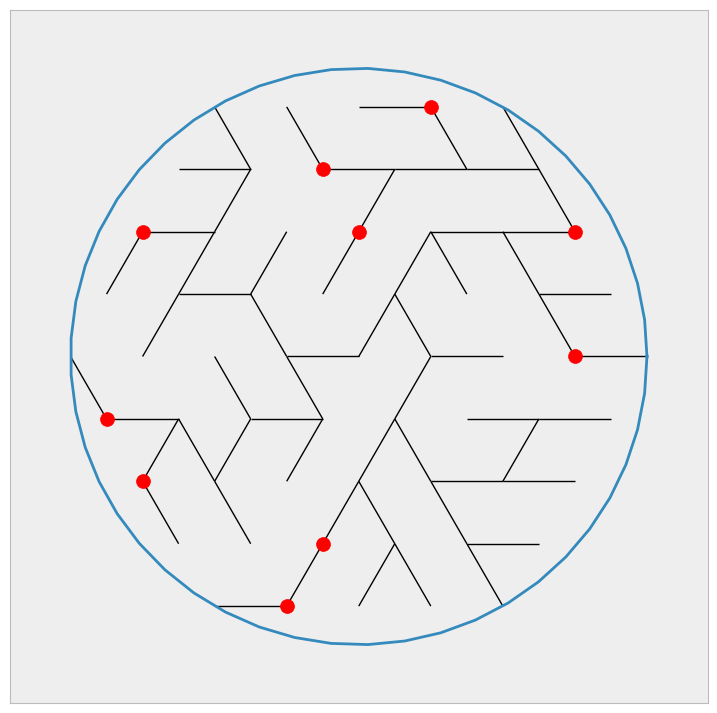

In [195]:
#runrun(81)

with open('Graph81.pickle', 'rb') as archivo:
    G2 = pickle.load(archivo)

plt.figure(figsize=(9,9))
plt.axis('equal')   
plt.style.use('bmh')
plt.grid(False)
   
angle = np.linspace( 0 , 2 *np.pi) 
 
radius = 4
x = radius * np.cos( angle ) 
y = radius * np.sin( angle ) 

plt.plot( x, y ) 

    
x= nx.get_node_attributes(G2, 'pos')

G2.add_edges_from(G2.edges)

#node_colors = ['red' if node == 13 else 'blue' for node in G2.nodes()]

nx.draw_networkx_nodes(G2, x, nodelist=nodosG2, node_color='red', node_size=100)
nx.draw_networkx_nodes(G2,x, node_shape='.', node_size=10.0, alpha= 0)
nx.draw_networkx_edges(G2,x)

#plt.savefig('red_revive.pdf')
plt.show()

In [194]:
import copy
L = len(G2.nodes())
print(L)
Gprima = G2
nodos, copia = clean(G2)
nodosG2 = []
for i in np.arange(L):
    if i not in nodos:
        nodosG2.append(i)

print(G2.nodes())
print(nodosG2)

#print(list(G.neighbors(13)))
# [14, 16, 22, 41, 43, 47, 48, 54, 56, 57]

61
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 44, 45, 46, 49, 50, 51, 52, 53, 55, 58, 59, 60]
[14, 16, 22, 41, 43, 47, 48, 54, 56, 57]


In [196]:
# Encontrar los ductos en el grafo
ductos = encontrar_ductos(G2)

# Imprimir información de los ductos
print("Número de ductos:", len(ductos))
for ducto, longitud in ductos.items():
    print("Ducto:", ducto, "Longitud:", longitud)

Número de ductos: 10
Ducto: (14,) Longitud: 2
Ducto: (16,) Longitud: 2
Ducto: (22,) Longitud: 2
Ducto: (41, 22.0) Longitud: 3
Ducto: (43,) Longitud: 2
Ducto: (47,) Longitud: 2
Ducto: (48,) Longitud: 2
Ducto: (54,) Longitud: 2
Ducto: (56,) Longitud: 2
Ducto: (57,) Longitud: 2
